In [1]:
from operator import attrgetter
from random import shuffle, choice, sample, random, uniform, randint
from copy import copy
from operator import attrgetter
import numpy as np
from itertools import product

### Charles

In [2]:
class Individual:
    # we always initialize
    def __init__(self, representation=None, size=None, valid_set=None, repetition=True):

        if representation is None:
            if repetition:
                # individual will be chosen from the valid_set with a specific size
                self.representation = [choice(valid_set) for i in range(size)]
            else:
                self.representation = sample(valid_set, size)

        # if we pass an argument like Individual(my_path)
        else:
            self.representation = representation

        # fitness will be assigned to the individual
        self.fitness = self.get_fitness()

    # methods for the class
    def get_fitness(self):
        raise Exception("You need to monkey patch the fitness function.")

    def get_neighbours(self):
        raise Exception("You need to monkey patch the neighbourhood function.")

    def index(self, value):
        return self.representation.index(value)

    def __len__(self):
        return len(self.representation)

    def __getitem__(self, position):
        return self.representation[position]

    def __setitem__(self, position, value):
        self.representation[position] = value

    def __repr__(self):
        return f" Fitness: {self.fitness}"


class Population:
    def __init__(self, size, optim, **kwargs):

        # population size
        self.size = size

        # defining the optimization problem as a minimization or maximization problem
        self.optim = optim

        self.individuals = []

        # appending the population with individuals
        for _ in range(size):
            self.individuals.append(
                Individual(
                    size=kwargs["sol_size"],
                    valid_set=kwargs["valid_set"],
                    repetition=kwargs["repetition"]
                )
            )
    def evolve(self, gens, xo_prob, mut_prob, select, xo, mutate, elitism):
        # gens = 100
        for i in range(gens):
            new_pop = []

            if elitism:
                if self.optim == "max":
                    elite = copy(max(self.individuals, key=attrgetter('fitness')))
                elif self.optim == "min":
                    elite = copy(min(self.individuals, key=attrgetter('fitness')))

                #new_pop.append(elite)

            while len(new_pop) < self.size:
                # selection
                parent1, parent2 = select(self), select(self)
                # xo with prob
                if random() < xo_prob:
                    offspring1, offspring2 = xo(parent1, parent2)
                # replication
                else:
                    offspring1, offspring2 = parent1, parent2
                # mutation with prob
                if random() < mut_prob:
                    offspring1 = mutate(offspring1)
                if random() < mut_prob:
                    offspring2 = mutate(offspring2)

                new_pop.append(Individual(representation=offspring1))
                if len(new_pop) < self.size:
                    new_pop.append(Individual(representation=offspring2))

            if elitism:
                if self.optim == "max":
                    worst = min(new_pop, key=attrgetter('fitness'))
                    if elite.fitness > worst.fitness:
                        new_pop.pop(new_pop.index(worst))
                        new_pop.append(elite)
                if self.optim == "min":
                    worst = max(new_pop, key=attrgetter('fitness'))
                    if elite.fitness < worst.fitness:
                        new_pop.pop(new_pop.index(worst))
                        new_pop.append(elite)


            self.individuals = new_pop

            # if self.optim == "max":
            #     print(f"Best individual of gen #{i + 1}: {max(self, key=attrgetter('fitness'))}")
            # elif self.optim == "min":
            #     print(f"Best individual of gen #{i + 1}: {min(self, key=attrgetter('fitness'))}")


    def __len__(self):
        return len(self.individuals)

    def __getitem__(self, position):
        return self.individuals[position]


### Selection

In [3]:
from operator import attrgetter
from random import uniform, choice


def fps(population):
    """Fitness proportionate selection implementation.

    Args:
        population (Population): The population we want to select from.

    Returns:
        Individual: selected individual.
    """
    if population.optim == "max":
        total_fitness = sum([i.fitness for i in population])
        r = uniform(0, total_fitness)
        position = 0
        for individual in population:
            position += individual.fitness
            if position > r:
                return individual
    elif population.optim == "min":
        inverted_fitness = [1.0 / (ind.fitness + 1e-10) for ind in population]
        total_inverted_fitness = sum(inverted_fitness)
        pick = uniform(0, total_inverted_fitness)
        current = 0
        for i, individual in enumerate(population):
            current += inverted_fitness[i]
            if current > pick:
                return individual
    else:
        raise Exception(f"Optimization not specified (max/min)")


def tournament_sel(population, tour_size=3):
    tournament = [choice(population) for _ in range(tour_size)]
    if population.optim == "max":
        return max(tournament, key=attrgetter('fitness'))
    elif population.optim == "min":
        return min(tournament, key=attrgetter('fitness'))

In [4]:
def rank_based_selection(population):
    """Rank-based selection implementation.
    
    Args:
        population (Population): The population to select from.
        
    Returns:
        Individual: Selected individual.
    """
    sorted_population = sorted(population.individuals, key=attrgetter('fitness'), reverse=(population.optim == "max"))
    n = len(sorted_population)
    total_rank = sum(range(1, n + 1))
    r = uniform(0, total_rank)
    position = 0
    for i, individual in enumerate(sorted_population):
        position += (i + 1)
        if position > r:
            return individual
        


def stochastic_universal_sampling(population):
    """Stochastic Universal Sampling implementation.
    
    Args:
        population (Population): The population to select from.
        
    Returns:
        Individual: Selected individual.
    """
    if population.optim == "max":
        total_fitness = sum(individual.fitness for individual in population.individuals)
        pointer_distance = total_fitness / len(population.individuals)
        start_point = uniform(0, pointer_distance)
        pointers = [start_point + i * pointer_distance for i in range(len(population.individuals))]
        
        individuals = []
        for pointer in pointers:
            position = 0
            for individual in population.individuals:
                position += individual.fitness
                if position >= pointer:
                    individuals.append(individual)
                    break
        return choice(individuals)
    elif population.optim == "min":
        # For minimization, we invert fitness values and apply the same logic as in maximization
        inverted_fitness = [1.0 / (individual.fitness + 1e-10) for individual in population.individuals]
        total_inverted_fitness = sum(inverted_fitness)
        pointer_distance = total_inverted_fitness / len(population.individuals)
        start_point = uniform(0, pointer_distance)
        pointers = [start_point + i * pointer_distance for i in range(len(population.individuals))]
        
        individuals = []
        for pointer in pointers:
            position = 0
            for individual, inv_fit in zip(population.individuals, inverted_fitness):
                position += inv_fit
                if position >= pointer:
                    individuals.append(individual)
                    break
        return choice(individuals)
    else:
        raise Exception(f"Optimization not specified (max/min)")


### Mutation

In [5]:
from random import randint, sample

def binary_mutation(individual):
    """Binary mutation for a GA individual

    Args:
        individual (Individual): A GA individual from charles.py

    Raises:
        Exception: When individual is not binary encoded.py

    Returns:
        Individual: Mutated Individual
    """
    mut_index = randint(0, len(individual)-1)
    if individual[mut_index] == 1:
        individual[mut_index] = 0
    elif individual[mut_index] == 0:
        individual[mut_index] = 1
    else:
        raise Exception("Representation is not binary!")

    return individual


def swap_mutation(individual, fixed_mask):
    """Swap mutation that respects fixed cells."""
    mutant = individual.representation[:]
    while True:
        idx1, idx2 = sample(range(81), 2)
        if not fixed_mask[idx1 // 9, idx1 % 9] and not fixed_mask[idx2 // 9, idx2 % 9]:
            mutant[idx1], mutant[idx2] = mutant[idx2], mutant[idx1]
            break
    return Individual(representation=mutant)


def inversion_mutation(ind, fixed_mask):
    """Inversion mutation that respects fixed cells.

    Args:
        ind (Individual): The individual to mutate.
        fixed_mask (np.array): Boolean mask indicating fixed values.

    Returns:
        Individual: Mutated individual.
    """
    size = len(ind.representation)
    start, end = sorted(sample(range(size), 2))
    segment = ind.representation[start:end]
    segment.reverse()
    
    new_repr = ind.representation[:start] + segment + ind.representation[end:]

    for i in range(size):
        if fixed_mask.flatten()[i]:
            new_repr[i] = ind.representation[i]

    return Individual(representation=new_repr)


In [6]:
def scramble_mutation(individual, fixed_mask):
    """Scramble mutation that respects fixed cells.
    
    Args:
        individual (Individual): The individual to mutate.
        fixed_mask (np.array): Boolean mask indicating fixed values.
        
    Returns:
        Individual: Mutated individual.
    """
    ind_copy = individual.representation[:]
    idxs = [i for i in range(len(ind_copy)) if not fixed_mask.flatten()[i]]
    if len(idxs) < 2:
        return individual
    idx1, idx2 = sorted(sample(idxs, 2))
    segment = ind_copy[idx1:idx2]
    shuffle(segment)
    ind_copy[idx1:idx2] = segment
    individual.representation = ind_copy
    return individual

In [7]:
def subgrid_swap_mutation(individual, fixed_mask):
    """Subgrid swap mutation that respects fixed cells."""
    mutant = individual.representation[:]

    # Select two different subgrids
    subgrid_indices = sample(range(9), 2)
    subgrid1, subgrid2 = subgrid_indices[0], subgrid_indices[1]

    # Get the cells within each subgrid
    subgrid1_cells = [idx for idx in range(81) if (idx // 27 == subgrid1 // 3) and ((idx // 3) % 3 == subgrid1 % 3)]
    subgrid2_cells = [idx for idx in range(81) if (idx // 27 == subgrid2 // 3) and ((idx // 3) % 3 == subgrid2 % 3)]

    # Shuffle the cells within each subgrid
    shuffle(subgrid1_cells)
    shuffle(subgrid2_cells)

    # Swap the values of the cells, ensuring fixed cells are not swapped
    for idx1, idx2 in zip(subgrid1_cells, subgrid2_cells):
        if not fixed_mask[idx1 // 9, idx1 % 9] and not fixed_mask[idx2 // 9, idx2 % 9]:
            mutant[idx1], mutant[idx2] = mutant[idx2], mutant[idx1]

    return Individual(representation=mutant)


### XO

In [8]:
from random import randint, sample, uniform


def single_point_xo(parent1, parent2, fixed_mask):
    """Single point crossover that respects fixed cells."""
    point = randint(1, len(parent1.representation) - 1)
    offspring1 = parent1.representation[:point] + parent2.representation[point:]
    offspring2 = parent2.representation[:point] + parent1.representation[point:]
    
    # Ensure offspring respect fixed values
    for i in range(len(offspring1)):
        if fixed_mask[i // 9, i % 9]:
            offspring1[i] = parent1.representation[i]
            offspring2[i] = parent2.representation[i]
    
    return Individual(representation=offspring1), Individual(representation=offspring2)


def cycle_xo(p1, p2, fixed_mask):
    """Implementation of cycle crossover that respects fixed cells.

    Args:
        p1 (Individual): First parent for crossover.
        p2 (Individual): Second parent for crossover.
        fixed_mask (np.array): Boolean mask indicating fixed values.

    Returns:
        tuple: Two offspring, resulting from the crossover.
    """
    # offspring placeholders
    offspring1 = [None] * len(p1.representation)
    offspring2 = [None] * len(p1.representation)

    while None in offspring1:
        index = offspring1.index(None)
        val1 = p1.representation[index]
        val2 = p2.representation[index]

        # copy the cycle elements
        while val1 != val2:
            offspring1[index] = p1.representation[index]
            offspring2[index] = p2.representation[index]
            val2 = p2.representation[index]
            index = p1.representation.index(val2)

        # copy the rest
        for i, element in enumerate(offspring1):
            if element is None:
                if fixed_mask.flatten()[i]:
                    offspring1[i] = p1.representation[i]
                    offspring2[i] = p2.representation[i]
                else:
                    offspring1[i] = p2.representation[i]
                    offspring2[i] = p1.representation[i]

    return Individual(representation=offspring1), Individual(representation=offspring2)


def geo_xo(p1, p2, fixed_mask):
    """Geometric crossover operator considering fixed cells.

    Args:
        p1 (Individual): First parent for crossover.
        p2 (Individual): Second parent for crossover.
        fixed_mask (list): A mask indicating fixed positions.

    Returns:
        Individuals: Two offspring, resulting from the crossover.
    """
    alpha = uniform(0, 1)
    offspring1 = [(alpha * p1[i] + (1 - alpha) * p2[i]) for i in range(len(p1))]
    offspring2 = [((1 - alpha) * p1[i] + alpha * p2[i]) for i in range(len(p1))]

    # Ensure fixed cells are maintained
    for i in range(len(p1)):
        if fixed_mask[i]:
            offspring1[i] = p1[i]
            offspring2[i] = p2[i]

    return offspring1, offspring2


In [9]:
def two_point_crossover(p1, p2, fixed_mask):
    """Two-point crossover that respects fixed cells.

    Args:
        p1 (Individual): First parent.
        p2 (Individual): Second parent.
        fixed_mask (np.array): Boolean mask indicating fixed values.

    Returns:
        tuple: Two offspring.
    """
    size = len(p1.representation)
    p1_repr = p1.representation[:]
    p2_repr = p2.representation[:]
    xo_point1, xo_point2 = sorted(sample(range(size), 2))

    offspring1 = p1_repr[:xo_point1] + p2_repr[xo_point1:xo_point2] + p1_repr[xo_point2:]
    offspring2 = p2_repr[:xo_point1] + p1_repr[xo_point1:xo_point2] + p2_repr[xo_point2:]

    for i in range(size):
        if fixed_mask.flatten()[i]:
            offspring1[i] = p1_repr[i]
            offspring2[i] = p2_repr[i]

    return Individual(representation=offspring1), Individual(representation=offspring2)



def uniform_crossover(parent1, parent2, fixed_mask, crossover_rate=0.5):
    """Uniform crossover that respects fixed cells.
    
    Args:
        parent1 (Individual): The first parent.
        parent2 (Individual): The second parent.
        fixed_mask (np.array): Boolean mask indicating fixed values.
        crossover_rate (float): Probability of swapping each gene.
        
    Returns:
        tuple: Two offspring individuals.
    """
    offspring1 = parent1.representation[:]
    offspring2 = parent2.representation[:]
    
    for i in range(len(parent1.representation)):
        if not fixed_mask.flatten()[i] and random() < crossover_rate:
            offspring1[i], offspring2[i] = offspring2[i], offspring1[i]
    
    return Individual(representation=offspring1), Individual(representation=offspring2)


In [10]:
def block_crossover(parent1, parent2, fixed_mask):
    """Block-based crossover that respects fixed cells."""
    offspring1 = parent1.representation[:]
    offspring2 = parent2.representation[:]
    block_indices = [(i, j) for i in range(0, 9, 3) for j in range(0, 9, 3)]
    
    block = sample(block_indices, 1)[0]
    for i in range(block[0], block[0] + 3):
        for j in range(block[1], block[1] + 3):
            idx = i * 9 + j
            if not fixed_mask.flatten()[idx]:
                offspring1[idx], offspring2[idx] = offspring2[idx], offspring1[idx]
                
    return Individual(representation=offspring1), Individual(representation=offspring2)

In [11]:
from copy import deepcopy
from random import seed, shuffle
import random as py_random

In [12]:
seed_value = 42

# Set seed for numpy and random
np.random.seed(seed_value)
py_random.seed(seed_value)

# Define the initial Sudoku puzzle and fixed cells
initial_puzzle = [
    [5, 3, 0, 0, 7, 0, 0, 0, 0],
    [6, 0, 0, 1, 9, 5, 0, 0, 0],
    [0, 9, 8, 0, 0, 0, 0, 6, 0],
    [8, 0, 0, 0, 6, 0, 0, 0, 3],
    [4, 0, 0, 8, 0, 3, 0, 0, 1],
    [7, 0, 0, 0, 2, 0, 0, 0, 6],
    [0, 6, 0, 0, 0, 0, 2, 8, 0],
    [0, 0, 0, 4, 1, 9, 0, 0, 5],
    [0, 0, 0, 0, 8, 0, 0, 7, 9]
]

fixed_values = np.array(initial_puzzle)
fixed_mask = fixed_values > 0

fixed_cells = [(r, c) for r in range(9) for c in range(9) if initial_puzzle[r][c] != 0]

# Utility functions
def print_sudoku(puzzle):
    for row in puzzle:
        print(" ".join(str(num) for num in row))
    print()

# Fitness function
def sudoku_fitness(individual):
    def count_duplicates(lst):
        return len(lst) - len(set(lst))

    puzzle = individual.representation
    fitness = 0

    puzzle_2d = [puzzle[i*9:(i+1)*9] for i in range(9)]

    for i in range(9):
        row = [puzzle_2d[i][j] for j in range(9)]
        col = [puzzle_2d[j][i] for j in range(9)]
        fitness += count_duplicates(row) + count_duplicates(col)

    for i in range(0, 9, 3):
        for j in range(0, 9, 3):
            block = [puzzle_2d[i+x][j+y] for x in range(3) for y in range(3)]
            fitness += count_duplicates(block)

    return fitness

# Monkey patch fitness and neighbors functions
Individual.get_fitness = sudoku_fitness

# Generate a random initial Sudoku solution
def generate_initial_solution(fixed_values, fixed_mask):
    solution = fixed_values.copy().flatten()
    for i in range(81):
        if not fixed_mask.flatten()[i]:
            solution[i] = py_random.choice(range(1, 10))
    return list(solution)

## Runing all combinations of slections methods, mutation operators and crossover operators

In [13]:
def main(seed_value, population_size, generations, crossover_prob, mutation_prob, elitism, sol_size, valid_set, select, xo, mutate):
    # Set the random seed
    np.random.seed(seed_value)
    py_random.seed(seed_value)

    # Generate initial population
    initial_population = [
        Individual(representation=generate_initial_solution(fixed_values, fixed_mask))
        for _ in range(population_size)
    ]

    # Create the Sudoku population
    sudoku_population = Population(
        size=population_size,
        optim="min",
        sol_size=sol_size,
        valid_set=valid_set,
        repetition=True
    )
    sudoku_population.individuals = initial_population

    best_individual = None
    for generation in range(generations):
        # Evolve the population for one generation
        sudoku_population.evolve(
            gens=1,
            xo_prob=crossover_prob,
            mut_prob=mutation_prob,
            select=select,
            xo=lambda p1, p2: xo(p1, p2, fixed_mask),
            mutate=lambda ind: mutate(ind, fixed_mask),
            elitism=elitism
        )

        # Find the current best individual
        current_best = min(sudoku_population, key=attrgetter('fitness'))
        
        # Update the best individual if needed
        if best_individual is None or current_best.fitness < best_individual.fitness:
            best_individual = deepcopy(current_best)

    return best_individual

def run_experiments():
    # Define combinations of methods
    selection_methods = [tournament_sel, rank_based_selection, fps, stochastic_universal_sampling]
    mutation_operators = [swap_mutation, scramble_mutation, subgrid_swap_mutation, inversion_mutation]
    crossover_operators = [single_point_xo, uniform_crossover, block_crossover, cycle_xo, two_point_crossover]

    results = []

    # Iterate over all combinations
    for select, xo, mutate in product(selection_methods, crossover_operators, mutation_operators):
        print(f"Running with selection: {select.__name__}, crossover: {xo.__name__}, mutation: {mutate.__name__}")
        best_solution = main(
            seed_value=seed_value,
            population_size=100,
            generations=500,
            crossover_prob=0.9,
            mutation_prob=0.1,
            elitism=True,
            sol_size=81,
            valid_set=list(range(1, 10)),
            select=select,
            xo=xo,
            mutate=mutate
        )
        results.append((select.__name__, xo.__name__, mutate.__name__, best_solution))

    # Sort results by fitness value (ascending order)
    results.sort(key=lambda x: x[3].fitness)

    # Print top 5 results
    for select_name, xo_name, mutate_name, best_solution in results[:5]:
        print(f"Selection: {select_name}, Crossover: {xo_name}, Mutation: {mutate_name}")
        puzzle_2d = [best_solution.representation[i*9:(i+1)*9] for i in range(9)]
        print_sudoku(puzzle_2d)
        print(f"Fitness: {best_solution.fitness}")

# Run the experiments
run_experiments()

Running with selection: tournament_sel, crossover: single_point_xo, mutation: swap_mutation
Running with selection: tournament_sel, crossover: single_point_xo, mutation: scramble_mutation
Running with selection: tournament_sel, crossover: single_point_xo, mutation: subgrid_swap_mutation
Running with selection: tournament_sel, crossover: single_point_xo, mutation: inversion_mutation
Running with selection: tournament_sel, crossover: uniform_crossover, mutation: swap_mutation
Running with selection: tournament_sel, crossover: uniform_crossover, mutation: scramble_mutation
Running with selection: tournament_sel, crossover: uniform_crossover, mutation: subgrid_swap_mutation
Running with selection: tournament_sel, crossover: uniform_crossover, mutation: inversion_mutation
Running with selection: tournament_sel, crossover: block_crossover, mutation: swap_mutation
Running with selection: tournament_sel, crossover: block_crossover, mutation: scramble_mutation
Running with selection: tournament

## DIFFERENT SUDOKU LEVELS

In [121]:
seed_value = 2

# Define a function to generate initial Sudoku puzzles with different difficulty levels
def generate_sudoku(difficulty='easy'):
    base = 3
    side = base * base

    # Pattern for a baseline valid solution
    def pattern(r, c): return (base * (r % base) + r // base + c) % side

    # Randomize rows, columns and numbers (of valid base pattern)
    def shuffle(s): return py_random.sample(s, len(s))
    rBase = range(base)
    rows = [g * base + r for g in shuffle(rBase) for r in shuffle(rBase)]
    cols = [g * base + c for g in shuffle(rBase) for c in shuffle(rBase)]
    nums = shuffle(range(1, base * base + 1))

    # Produce board using randomized baseline pattern
    board = [[nums[pattern(r, c)] for c in cols] for r in rows]

    # Remove elements to create the puzzle based on difficulty
    squares = side * side
    empties = {
        'easy': squares // 4,
        'medium': squares // 2,
        'hard': 3 * squares // 4
    }.get(difficulty, squares // 2)

    for p in py_random.sample(range(squares), empties):
        board[p // side][p % side] = 0

    return board

# Utility function to pretty print the Sudoku puzzle
def pretty_print_sudoku(puzzle):
    for i, row in enumerate(puzzle):
        if i % 3 == 0 and i != 0:
            print("-" * 21)
        for j, num in enumerate(row):
            if j % 3 == 0 and j != 0:
                print("|", end=" ")
            print(num if num != 0 else ".", end=" ")
        print()
    print()

# Fitness function
def sudoku_fitness(individual):
    def count_duplicates(lst):
        return len(lst) - len(set(lst))

    puzzle = individual.representation
    fitness = 0

    puzzle_2d = [puzzle[i * 9:(i + 1) * 9] for i in range(9)]

    for i in range(9):
        row = [puzzle_2d[i][j] for j in range(9)]
        col = [puzzle_2d[j][i] for j in range(9)]
        fitness += count_duplicates(row) + count_duplicates(col)

    for i in range(0, 9, 3):
        for j in range(0, 9, 3):
            block = [puzzle_2d[i + x][j + y] for x in range(3) for y in range(3)]
            fitness += count_duplicates(block)

    return fitness


# Monkey patch fitness and neighbors functions
Individual.get_fitness = sudoku_fitness

# Generate a random initial Sudoku solution
def generate_initial_solution(fixed_values, fixed_mask):    
    solution = fixed_values.copy().flatten()
    for i in range(81):
        if not fixed_mask.flatten()[i]:
            solution[i] = py_random.choice(range(1, 10))
    return list(solution)

## Main function for grid search

In [122]:
def main(population_size, generations, crossover_prob, mutation_prob, elitism, sol_size, valid_set, 
         select_method, crossover_operator, mutation_operator):

    np.random.seed(seed_value)
    py_random.seed(seed_value)
    
    initial_population = [
        Individual(representation=generate_initial_solution(fixed_values, fixed_mask))
        for _ in range(population_size)
    ]

    sudoku_population = Population(
        size=population_size,
        optim="min",
        sol_size=sol_size,
        valid_set=valid_set,
        repetition=True
    )
    sudoku_population.individuals = initial_population

    best_individual = None

    fitness_data = {
        'generation': [],
        'best_fitness': [],
        'average_fitness': [],
        'worst_fitness': [],
        'diversity': []
    }

    for generation in range(generations):
        sudoku_population.evolve(
            gens=1,
            xo_prob=crossover_prob,
            mut_prob=mutation_prob,
            select=select_method,
            xo=lambda p1, p2: crossover_operator(p1, p2, fixed_mask),
            mutate=lambda ind: mutation_operator(ind, fixed_mask),
            elitism=elitism
        )

        fitness_values = [individual.fitness for individual in sudoku_population.individuals]
        best_fitness = min(fitness_values)
        avg_fitness = np.mean(fitness_values)
        worst_fitness = max(fitness_values)
        diversity = np.std(fitness_values)

        fitness_data['generation'].append(generation)
        fitness_data['best_fitness'].append(best_fitness)
        fitness_data['average_fitness'].append(avg_fitness)
        fitness_data['worst_fitness'].append(worst_fitness)
        fitness_data['diversity'].append(diversity)

        current_best = min(sudoku_population, key=attrgetter('fitness'))
        if best_individual is None or current_best.fitness < best_individual.fitness:
            best_individual = deepcopy(current_best)

        # Early stopping condition
        if best_individual.fitness == 0:
            print(f"Early stopping at generation {generation} with fitness 0")
            break

    return best_individual, fitness_data


def grid_search(select_methods, crossover_operators, mutation_operators):

    np.random.seed(seed_value)
    py_random.seed(seed_value)
    
    param_grid = {
        'population_size': [500],
        'generations': [400],
        'crossover_prob': [0.8, 0.9, 0.95],
        'mutation_prob': [0.05, 0.1, 0.15],
        'elitism': [True]
    }
    best_params = None
    best_fitness = float('inf')
    best_solution = None
    best_fitness_data = None

    for params in product(*param_grid.values()):
        population_size, generations, crossover_prob, mutation_prob, elitism = params
        print(f"Testing parameters: population_size={population_size}, generations={generations}, crossover_prob={crossover_prob}, mutation_prob={mutation_prob}, elitism={elitism}")

        solution, fitness_data = main(population_size, generations, crossover_prob, mutation_prob, elitism, 81, list(range(1, 10)),
                                      select_method=select_methods,
                                      crossover_operator=crossover_operators,
                                      mutation_operator=mutation_operators)
        fitness = solution.fitness

        if fitness < best_fitness:
            best_fitness = fitness
            best_params = params
            best_solution = solution
            best_fitness_data = fitness_data

        print(f"Current best fitness: {best_fitness} with parameters {best_params}")

        # Early stopping if a perfect solution is found
        if best_fitness == 0:
            print(f"Perfect solution found with parameters {best_params}")
            break

    return best_params, best_solution, best_fitness_data



## Plot function

In [123]:
import matplotlib.pyplot as plt

def plot_fitness_data(best_fitness_data):
    plt.figure(figsize=(14, 8))

    # Plotting the fitness over generations
    plt.subplot(2, 1, 1)
    plt.plot(best_fitness_data['generation'], best_fitness_data['best_fitness'], label='Best Fitness')
    plt.plot(best_fitness_data['generation'], best_fitness_data['average_fitness'], label='Average Fitness')
    plt.plot(best_fitness_data['generation'], best_fitness_data['worst_fitness'], label='Worst Fitness')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.title('Fitness over Generations')
    plt.legend()

    # Plotting the diversity over generations
    plt.subplot(2, 1, 2)
    plt.plot(best_fitness_data['generation'], best_fitness_data['diversity'], label='Diversity', color='orange')
    plt.xlabel('Generation')
    plt.ylabel('Diversity')
    plt.title('Population Diversity over Generations')
    plt.legend()

    plt.tight_layout()
    plt.show()


## EASY

#### tournament_sel, uniform_crossover, swap_mutation

In [124]:
difficulty = 'easy'
initial_puzzle = generate_sudoku(difficulty)

fixed_values = np.array(initial_puzzle)
fixed_mask = fixed_values > 0

fixed_cells = [(r, c) for r in range(9) for c in range(9) if initial_puzzle[r][c] != 0]

best_params, best_solution, best_fitness_data = grid_search(tournament_sel, uniform_crossover, swap_mutation)

print("Best parameters found:")
print(f"Population size: {best_params[0]}")
print(f"Generations: {best_params[1]}")
print(f"Crossover probability: {best_params[2]}")
print(f"Mutation probability: {best_params[3]}")
print(f"Elitism: {best_params[4]}")

print("Best solution found:")
puzzle_2d = [best_solution.representation[i * 9:(i + 1) * 9] for i in range(9)]
pretty_print_sudoku(puzzle_2d)
print(f"Fitness: {best_solution.fitness}")

Testing parameters: population_size=500, generations=400, crossover_prob=0.8, mutation_prob=0.05, elitism=True
Early stopping at generation 16 with fitness 0
Current best fitness: 0 with parameters (500, 400, 0.8, 0.05, True)
Perfect solution found with parameters (500, 400, 0.8, 0.05, True)
Best parameters found:
Population size: 500
Generations: 400
Crossover probability: 0.8
Mutation probability: 0.05
Elitism: True
Best solution found:
7 2 4 | 5 6 1 | 3 8 9 
5 1 6 | 3 9 8 | 7 2 4 
3 8 9 | 7 4 2 | 5 1 6 
---------------------
2 9 7 | 1 5 4 | 8 6 3 
8 6 3 | 2 7 9 | 1 4 5 
1 4 5 | 8 3 6 | 2 9 7 
---------------------
6 5 8 | 9 2 3 | 4 7 1 
4 7 1 | 6 8 5 | 9 3 2 
9 3 2 | 4 1 7 | 6 5 8 

Fitness: 0


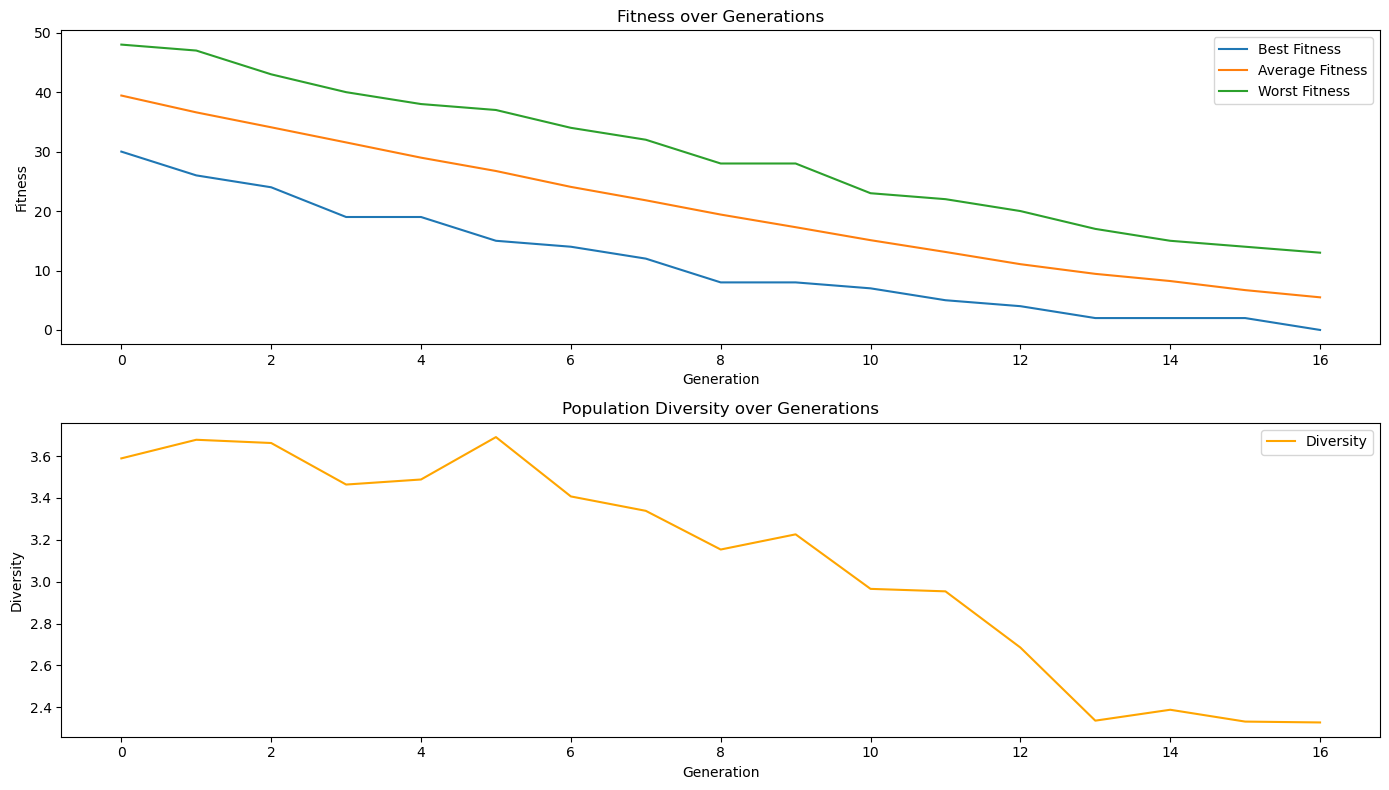

In [125]:
plot_fitness_data(best_fitness_data)

## MEDIUM

#### tournament_sel, uniform_crossover, swap_mutation

In [127]:
difficulty = 'medium'
initial_puzzle = generate_sudoku(difficulty)

fixed_values = np.array(initial_puzzle)
fixed_mask = fixed_values > 0

fixed_cells = [(r, c) for r in range(9) for c in range(9) if initial_puzzle[r][c] != 0]

best_params, best_solution, best_fitness_data = grid_search(tournament_sel, uniform_crossover, swap_mutation)

print("Best parameters found:")
print(f"Population size: {best_params[0]}")
print(f"Generations: {best_params[1]}")
print(f"Crossover probability: {best_params[2]}")
print(f"Mutation probability: {best_params[3]}")
print(f"Elitism: {best_params[4]}")

print("Best solution found:")
puzzle_2d = [best_solution.representation[i * 9:(i + 1) * 9] for i in range(9)]
pretty_print_sudoku(puzzle_2d)
print(f"Fitness: {best_solution.fitness}")

Testing parameters: population_size=500, generations=400, crossover_prob=0.8, mutation_prob=0.05, elitism=True
Early stopping at generation 203 with fitness 0
Current best fitness: 0 with parameters (500, 400, 0.8, 0.05, True)
Perfect solution found with parameters (500, 400, 0.8, 0.05, True)
Best parameters found:
Population size: 500
Generations: 400
Crossover probability: 0.8
Mutation probability: 0.05
Elitism: True
Best solution found:
8 7 6 | 1 4 9 | 2 5 3 
9 1 4 | 2 5 3 | 7 6 8 
3 2 5 | 7 6 8 | 1 4 9 
---------------------
7 5 3 | 6 8 1 | 4 9 2 
1 6 8 | 4 9 2 | 5 3 7 
2 4 9 | 5 3 7 | 6 8 1 
---------------------
5 9 2 | 3 7 6 | 8 1 4 
6 3 7 | 8 1 4 | 9 2 5 
4 8 1 | 9 2 5 | 3 7 6 

Fitness: 0


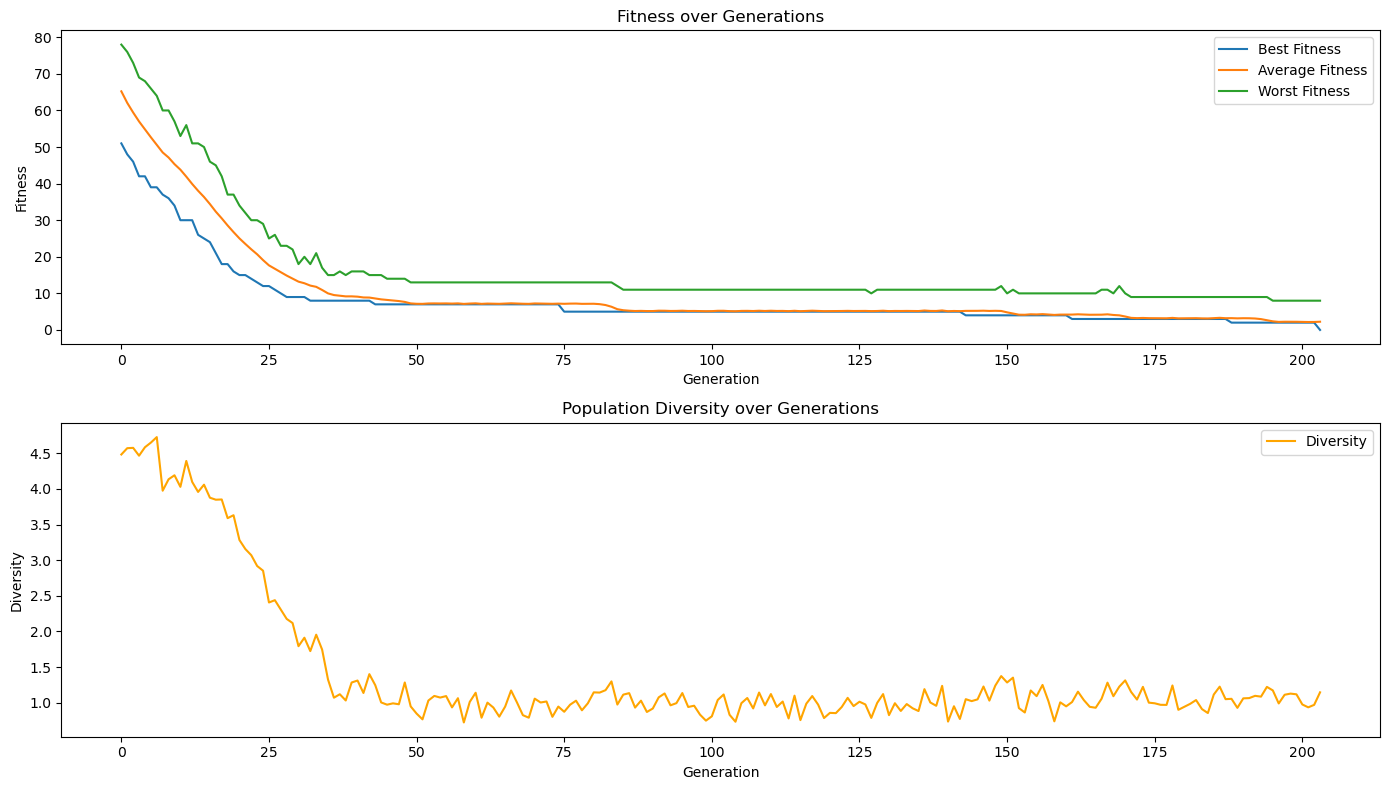

In [128]:
plot_fitness_data(best_fitness_data)

#### fps, single_point_xo, swap_mutation

In [129]:
best_params, best_solution, best_fitness_data = grid_search(fps, single_point_xo, swap_mutation)

print("Best parameters found:")
print(f"Population size: {best_params[0]}")
print(f"Generations: {best_params[1]}")
print(f"Crossover probability: {best_params[2]}")
print(f"Mutation probability: {best_params[3]}")
print(f"Elitism: {best_params[4]}")

print("Best solution found:")
puzzle_2d = [best_solution.representation[i * 9:(i + 1) * 9] for i in range(9)]
pretty_print_sudoku(puzzle_2d)
print(f"Fitness: {best_solution.fitness}")

Testing parameters: population_size=500, generations=400, crossover_prob=0.8, mutation_prob=0.05, elitism=True
Current best fitness: 8 with parameters (500, 400, 0.8, 0.05, True)
Testing parameters: population_size=500, generations=400, crossover_prob=0.8, mutation_prob=0.1, elitism=True
Current best fitness: 8 with parameters (500, 400, 0.8, 0.05, True)
Testing parameters: population_size=500, generations=400, crossover_prob=0.8, mutation_prob=0.15, elitism=True
Current best fitness: 6 with parameters (500, 400, 0.8, 0.15, True)
Testing parameters: population_size=500, generations=400, crossover_prob=0.9, mutation_prob=0.05, elitism=True
Current best fitness: 5 with parameters (500, 400, 0.9, 0.05, True)
Testing parameters: population_size=500, generations=400, crossover_prob=0.9, mutation_prob=0.1, elitism=True
Current best fitness: 5 with parameters (500, 400, 0.9, 0.05, True)
Testing parameters: population_size=500, generations=400, crossover_prob=0.9, mutation_prob=0.15, elitism=T

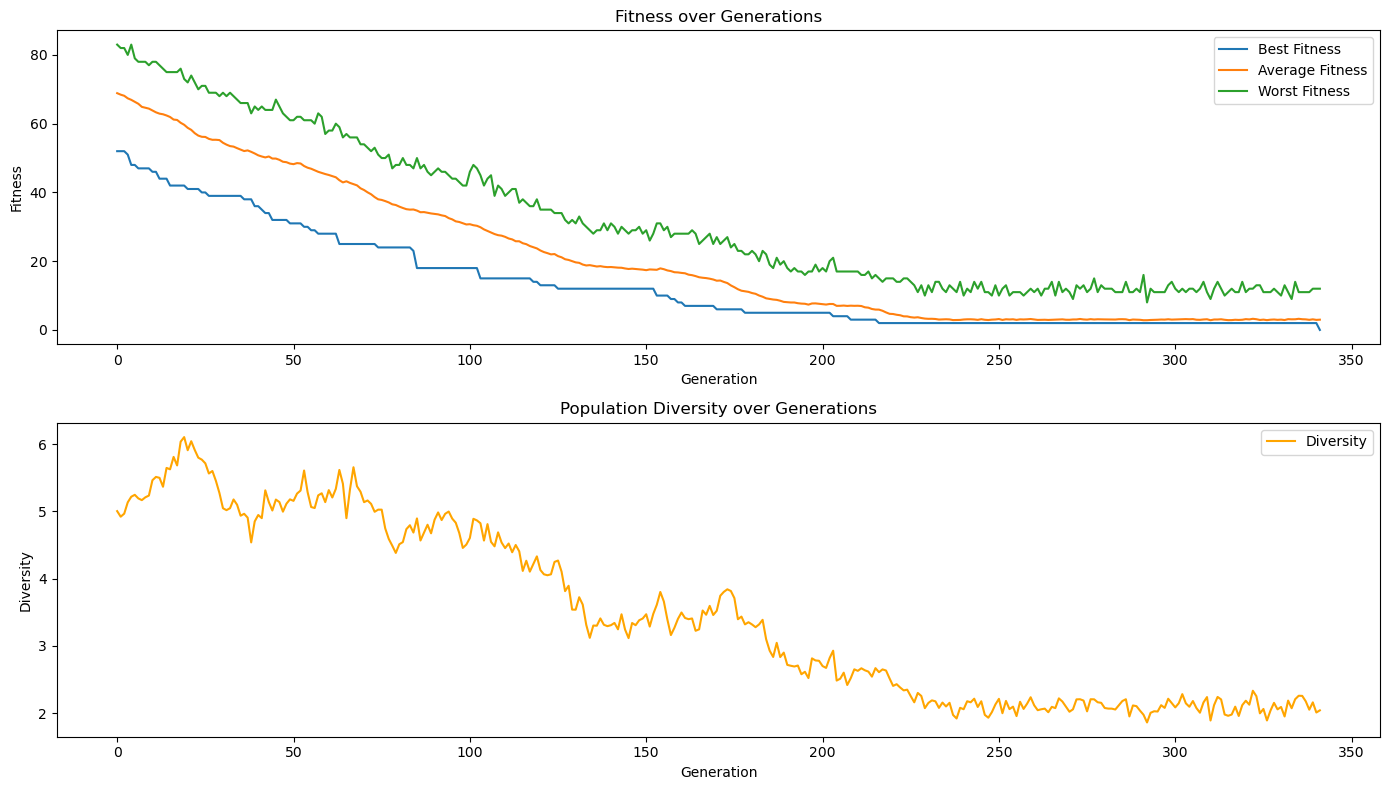

In [130]:
plot_fitness_data(best_fitness_data)

#### fps, uniform_crossover, subgrid_swap_mutation

In [131]:
best_params, best_solution, best_fitness_data = grid_search(fps, uniform_crossover, subgrid_swap_mutation)

print("Best parameters found:")
print(f"Population size: {best_params[0]}")
print(f"Generations: {best_params[1]}")
print(f"Crossover probability: {best_params[2]}")
print(f"Mutation probability: {best_params[3]}")
print(f"Elitism: {best_params[4]}")

print("Best solution found:")
puzzle_2d = [best_solution.representation[i * 9:(i + 1) * 9] for i in range(9)]
pretty_print_sudoku(puzzle_2d)
print(f"Fitness: {best_solution.fitness}")

Testing parameters: population_size=500, generations=400, crossover_prob=0.8, mutation_prob=0.05, elitism=True
Current best fitness: 4 with parameters (500, 400, 0.8, 0.05, True)
Testing parameters: population_size=500, generations=400, crossover_prob=0.8, mutation_prob=0.1, elitism=True
Current best fitness: 4 with parameters (500, 400, 0.8, 0.05, True)
Testing parameters: population_size=500, generations=400, crossover_prob=0.8, mutation_prob=0.15, elitism=True
Early stopping at generation 266 with fitness 0
Current best fitness: 0 with parameters (500, 400, 0.8, 0.15, True)
Perfect solution found with parameters (500, 400, 0.8, 0.15, True)
Best parameters found:
Population size: 500
Generations: 400
Crossover probability: 0.8
Mutation probability: 0.15
Elitism: True
Best solution found:
8 7 6 | 1 4 9 | 2 5 3 
9 1 4 | 2 5 3 | 7 6 8 
3 2 5 | 7 6 8 | 1 4 9 
---------------------
7 5 3 | 6 8 1 | 4 9 2 
1 6 8 | 4 9 2 | 5 3 7 
2 4 9 | 5 3 7 | 6 8 1 
---------------------
5 9 2 | 3 7 6 | 8

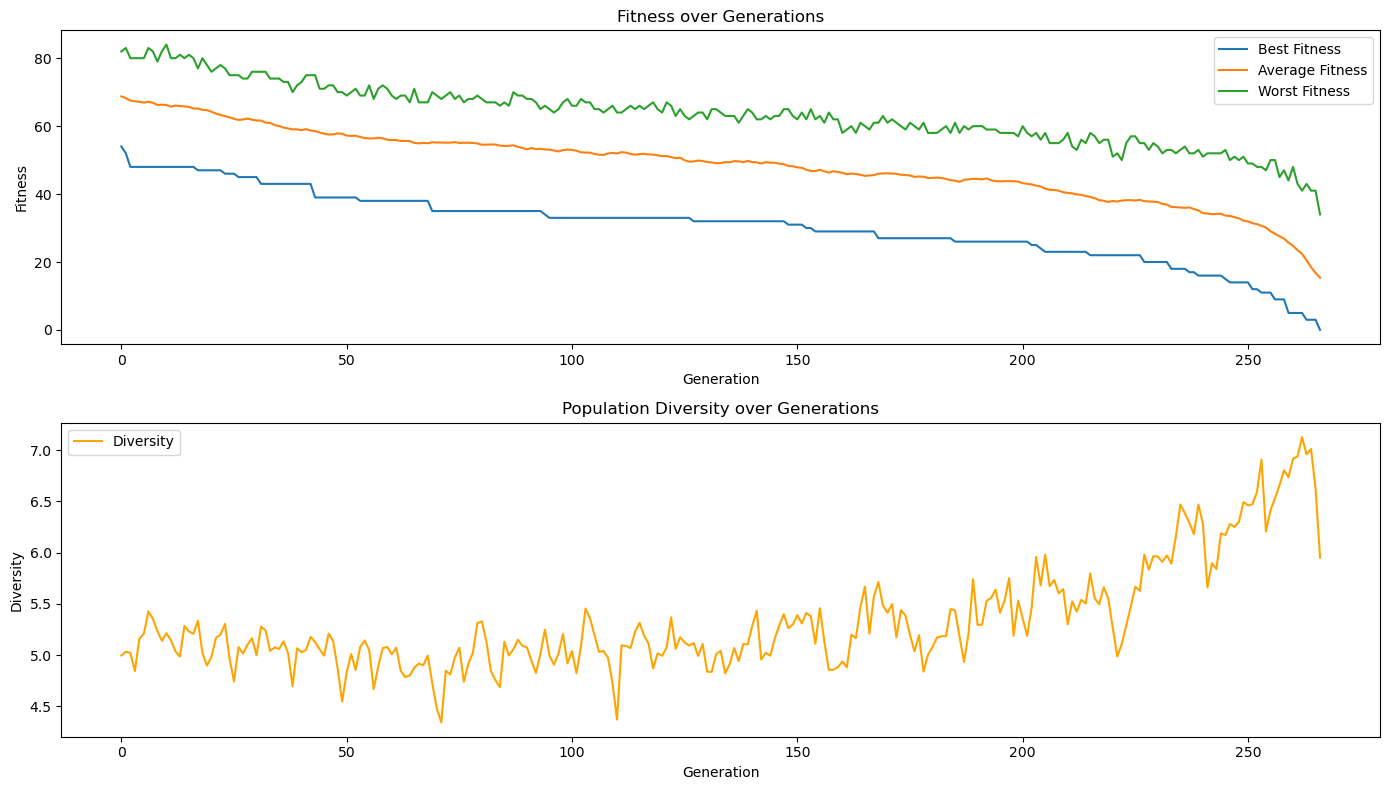

In [132]:
plot_fitness_data(best_fitness_data)

##### tournament_sel, two_point_crossover, swap_mutation

In [133]:
best_params, best_solution, best_fitness_data = grid_search(tournament_sel, two_point_crossover, swap_mutation)

print("Best parameters found:")
print(f"Population size: {best_params[0]}")
print(f"Generations: {best_params[1]}")
print(f"Crossover probability: {best_params[2]}")
print(f"Mutation probability: {best_params[3]}")
print(f"Elitism: {best_params[4]}")

print("Best solution found:")
puzzle_2d = [best_solution.representation[i * 9:(i + 1) * 9] for i in range(9)]
pretty_print_sudoku(puzzle_2d)
print(f"Fitness: {best_solution.fitness}")

Testing parameters: population_size=500, generations=400, crossover_prob=0.8, mutation_prob=0.05, elitism=True
Current best fitness: 4 with parameters (500, 400, 0.8, 0.05, True)
Testing parameters: population_size=500, generations=400, crossover_prob=0.8, mutation_prob=0.1, elitism=True
Current best fitness: 4 with parameters (500, 400, 0.8, 0.05, True)
Testing parameters: population_size=500, generations=400, crossover_prob=0.8, mutation_prob=0.15, elitism=True
Current best fitness: 4 with parameters (500, 400, 0.8, 0.05, True)
Testing parameters: population_size=500, generations=400, crossover_prob=0.9, mutation_prob=0.05, elitism=True
Current best fitness: 4 with parameters (500, 400, 0.8, 0.05, True)
Testing parameters: population_size=500, generations=400, crossover_prob=0.9, mutation_prob=0.1, elitism=True
Current best fitness: 4 with parameters (500, 400, 0.8, 0.05, True)
Testing parameters: population_size=500, generations=400, crossover_prob=0.9, mutation_prob=0.15, elitism=T

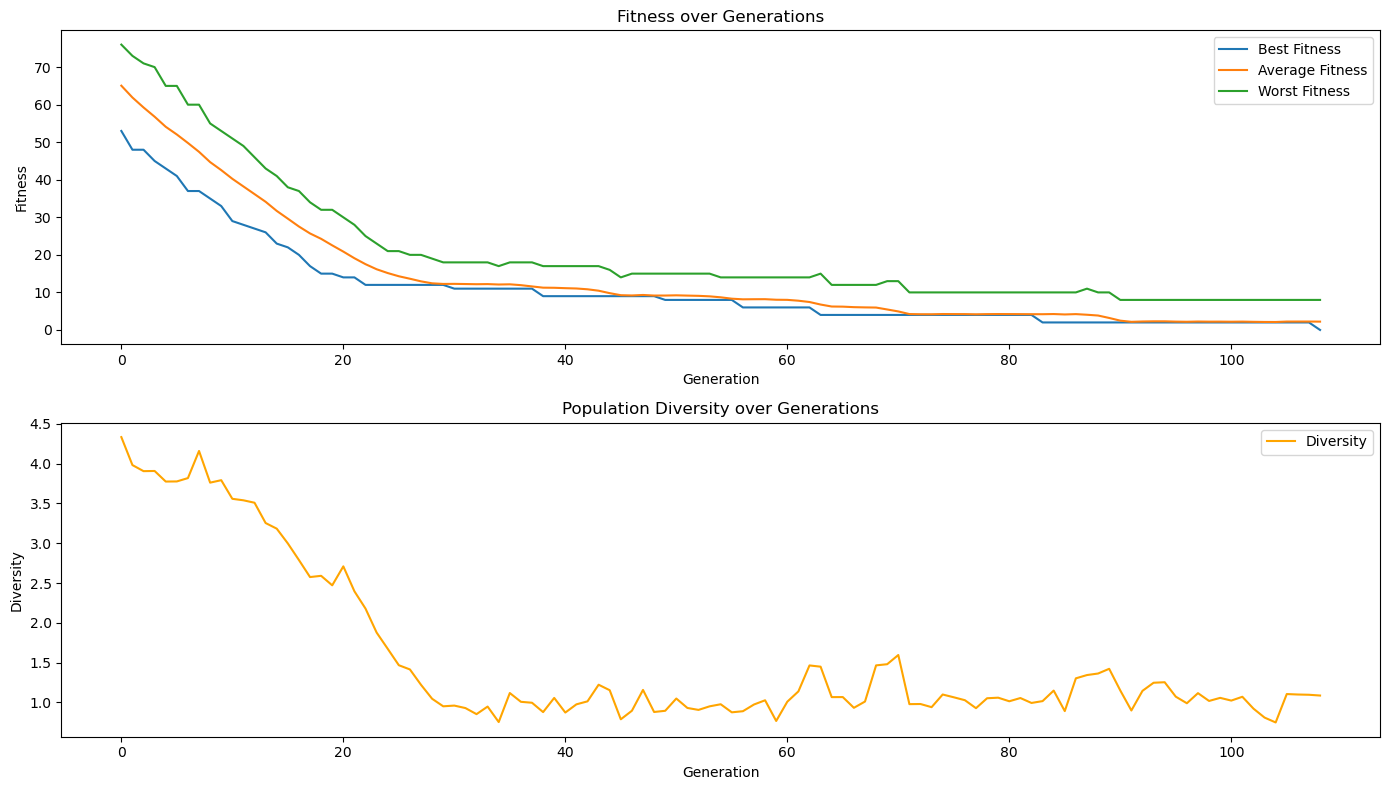

In [134]:
plot_fitness_data(best_fitness_data)

## HARD

#### tournament_sel, uniform_crossover, swap_mutation

In [136]:
difficulty = 'hard'
initial_puzzle = generate_sudoku(difficulty)

fixed_values = np.array(initial_puzzle)
fixed_mask = fixed_values > 0

fixed_cells = [(r, c) for r in range(9) for c in range(9) if initial_puzzle[r][c] != 0]

best_params, best_solution, best_fitness_data = grid_search(tournament_sel, uniform_crossover, swap_mutation)

print("Best parameters found:")
print(f"Population size: {best_params[0]}")
print(f"Generations: {best_params[1]}")
print(f"Crossover probability: {best_params[2]}")
print(f"Mutation probability: {best_params[3]}")
print(f"Elitism: {best_params[4]}")

print("Best solution found:")
puzzle_2d = [best_solution.representation[i * 9:(i + 1) * 9] for i in range(9)]
pretty_print_sudoku(puzzle_2d)
print(f"Fitness: {best_solution.fitness}")

Testing parameters: population_size=500, generations=400, crossover_prob=0.8, mutation_prob=0.05, elitism=True
Current best fitness: 4 with parameters (500, 400, 0.8, 0.05, True)
Testing parameters: population_size=500, generations=400, crossover_prob=0.8, mutation_prob=0.1, elitism=True
Current best fitness: 2 with parameters (500, 400, 0.8, 0.1, True)
Testing parameters: population_size=500, generations=400, crossover_prob=0.8, mutation_prob=0.15, elitism=True
Current best fitness: 2 with parameters (500, 400, 0.8, 0.1, True)
Testing parameters: population_size=500, generations=400, crossover_prob=0.9, mutation_prob=0.05, elitism=True
Current best fitness: 2 with parameters (500, 400, 0.8, 0.1, True)
Testing parameters: population_size=500, generations=400, crossover_prob=0.9, mutation_prob=0.1, elitism=True
Current best fitness: 2 with parameters (500, 400, 0.8, 0.1, True)
Testing parameters: population_size=500, generations=400, crossover_prob=0.9, mutation_prob=0.15, elitism=True


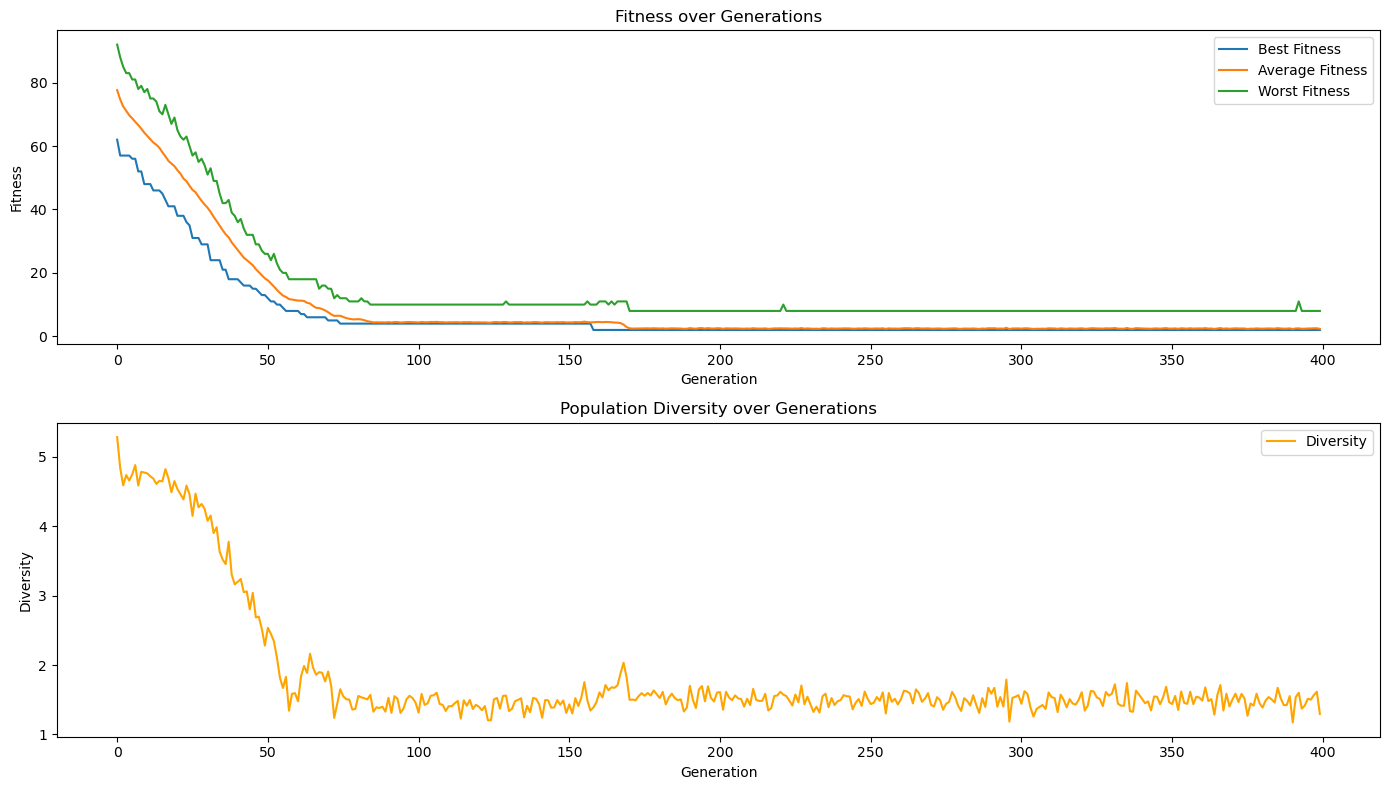

In [137]:
plot_fitness_data(best_fitness_data)

#### fps, single_point_xo, swap_mutation

In [138]:
best_params, best_solution, best_fitness_data = grid_search(fps, single_point_xo, swap_mutation)

print("Best parameters found:")
print(f"Population size: {best_params[0]}")
print(f"Generations: {best_params[1]}")
print(f"Crossover probability: {best_params[2]}")
print(f"Mutation probability: {best_params[3]}")
print(f"Elitism: {best_params[4]}")

print("Best solution found:")
puzzle_2d = [best_solution.representation[i * 9:(i + 1) * 9] for i in range(9)]
pretty_print_sudoku(puzzle_2d)
print(f"Fitness: {best_solution.fitness}")

Testing parameters: population_size=500, generations=400, crossover_prob=0.8, mutation_prob=0.05, elitism=True
Current best fitness: 9 with parameters (500, 400, 0.8, 0.05, True)
Testing parameters: population_size=500, generations=400, crossover_prob=0.8, mutation_prob=0.1, elitism=True
Current best fitness: 9 with parameters (500, 400, 0.8, 0.05, True)
Testing parameters: population_size=500, generations=400, crossover_prob=0.8, mutation_prob=0.15, elitism=True
Current best fitness: 9 with parameters (500, 400, 0.8, 0.05, True)
Testing parameters: population_size=500, generations=400, crossover_prob=0.9, mutation_prob=0.05, elitism=True
Current best fitness: 9 with parameters (500, 400, 0.8, 0.05, True)
Testing parameters: population_size=500, generations=400, crossover_prob=0.9, mutation_prob=0.1, elitism=True
Current best fitness: 9 with parameters (500, 400, 0.8, 0.05, True)
Testing parameters: population_size=500, generations=400, crossover_prob=0.9, mutation_prob=0.15, elitism=T

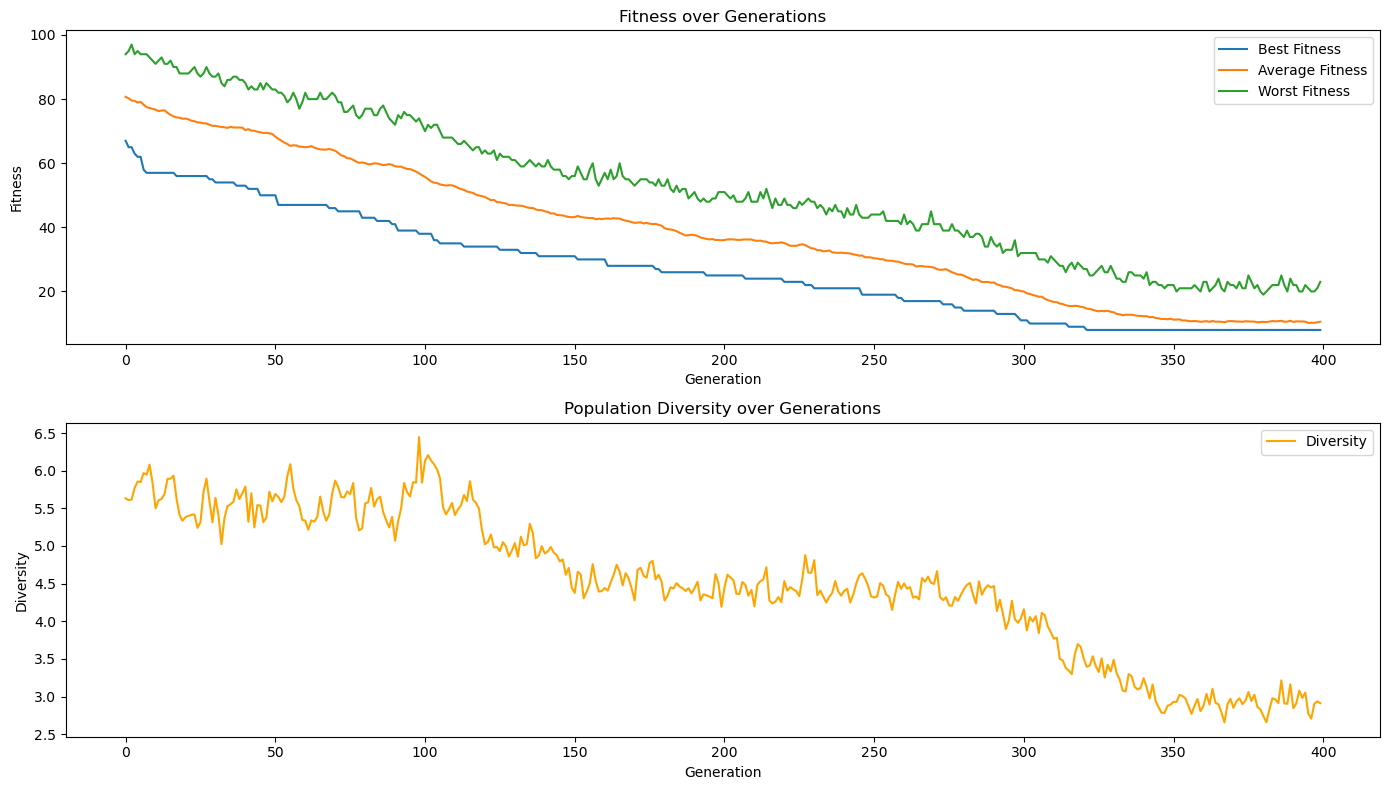

In [139]:
plot_fitness_data(best_fitness_data)

#### fps, uniform_crossover, subgrid_swap_mutation

In [140]:
best_params, best_solution, best_fitness_data = grid_search(fps, uniform_crossover, subgrid_swap_mutation)

print("Best parameters found:")
print(f"Population size: {best_params[0]}")
print(f"Generations: {best_params[1]}")
print(f"Crossover probability: {best_params[2]}")
print(f"Mutation probability: {best_params[3]}")
print(f"Elitism: {best_params[4]}")

print("Best solution found:")
puzzle_2d = [best_solution.representation[i * 9:(i + 1) * 9] for i in range(9)]
pretty_print_sudoku(puzzle_2d)
print(f"Fitness: {best_solution.fitness}")

Testing parameters: population_size=500, generations=400, crossover_prob=0.8, mutation_prob=0.05, elitism=True
Current best fitness: 8 with parameters (500, 400, 0.8, 0.05, True)
Testing parameters: population_size=500, generations=400, crossover_prob=0.8, mutation_prob=0.1, elitism=True
Current best fitness: 8 with parameters (500, 400, 0.8, 0.05, True)
Testing parameters: population_size=500, generations=400, crossover_prob=0.8, mutation_prob=0.15, elitism=True
Current best fitness: 8 with parameters (500, 400, 0.8, 0.05, True)
Testing parameters: population_size=500, generations=400, crossover_prob=0.9, mutation_prob=0.05, elitism=True
Current best fitness: 8 with parameters (500, 400, 0.8, 0.05, True)
Testing parameters: population_size=500, generations=400, crossover_prob=0.9, mutation_prob=0.1, elitism=True
Current best fitness: 8 with parameters (500, 400, 0.8, 0.05, True)
Testing parameters: population_size=500, generations=400, crossover_prob=0.9, mutation_prob=0.15, elitism=T

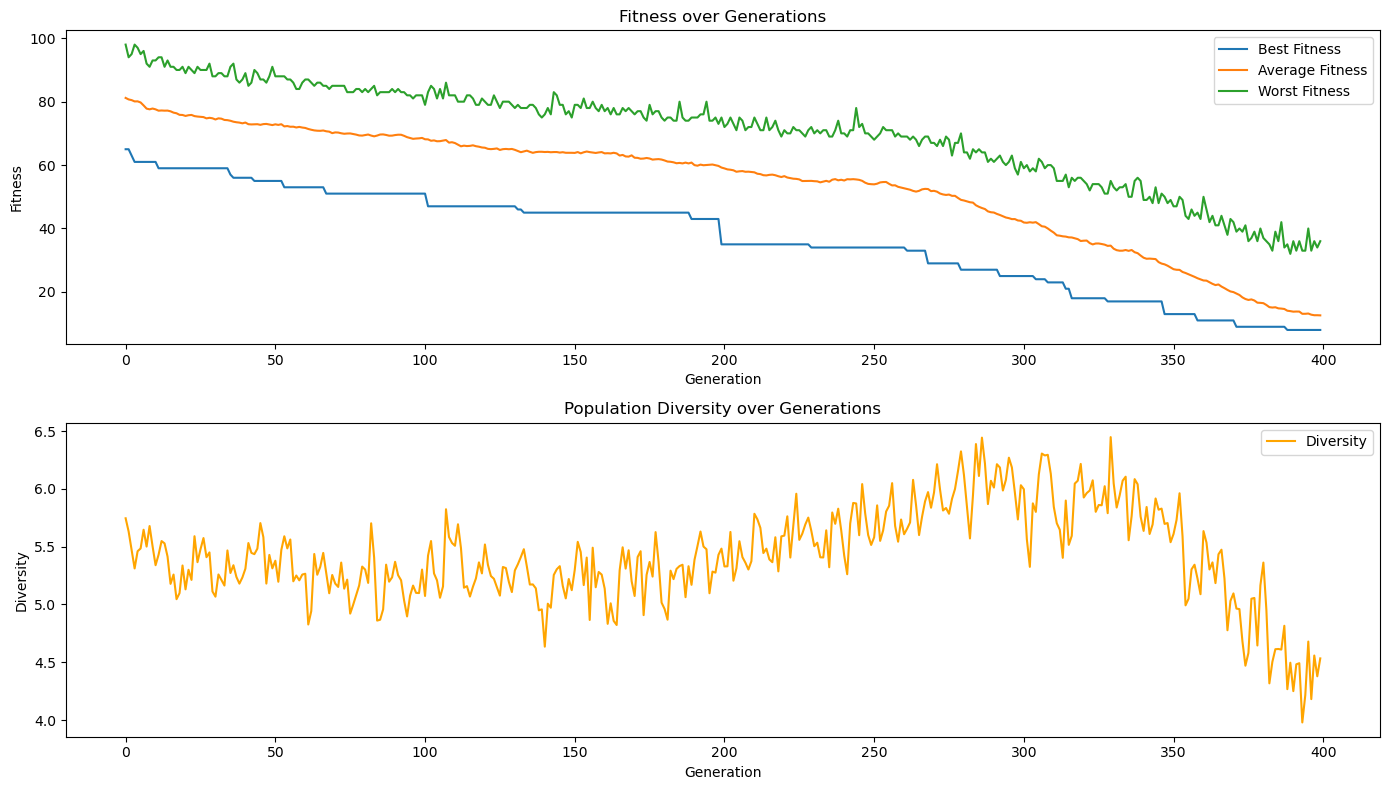

In [141]:
plot_fitness_data(best_fitness_data)

#### tournament_sel, two_point_crossover, swap_mutation

In [142]:
best_params, best_solution, best_fitness_data = grid_search(tournament_sel, two_point_crossover, swap_mutation)

print("Best parameters found:")
print(f"Population size: {best_params[0]}")
print(f"Generations: {best_params[1]}")
print(f"Crossover probability: {best_params[2]}")
print(f"Mutation probability: {best_params[3]}")
print(f"Elitism: {best_params[4]}")

print("Best solution found:")
puzzle_2d = [best_solution.representation[i * 9:(i + 1) * 9] for i in range(9)]
pretty_print_sudoku(puzzle_2d)
print(f"Fitness: {best_solution.fitness}")

Testing parameters: population_size=500, generations=400, crossover_prob=0.8, mutation_prob=0.05, elitism=True
Current best fitness: 8 with parameters (500, 400, 0.8, 0.05, True)
Testing parameters: population_size=500, generations=400, crossover_prob=0.8, mutation_prob=0.1, elitism=True
Current best fitness: 6 with parameters (500, 400, 0.8, 0.1, True)
Testing parameters: population_size=500, generations=400, crossover_prob=0.8, mutation_prob=0.15, elitism=True
Current best fitness: 6 with parameters (500, 400, 0.8, 0.1, True)
Testing parameters: population_size=500, generations=400, crossover_prob=0.9, mutation_prob=0.05, elitism=True
Current best fitness: 6 with parameters (500, 400, 0.8, 0.1, True)
Testing parameters: population_size=500, generations=400, crossover_prob=0.9, mutation_prob=0.1, elitism=True
Current best fitness: 6 with parameters (500, 400, 0.8, 0.1, True)
Testing parameters: population_size=500, generations=400, crossover_prob=0.9, mutation_prob=0.15, elitism=True


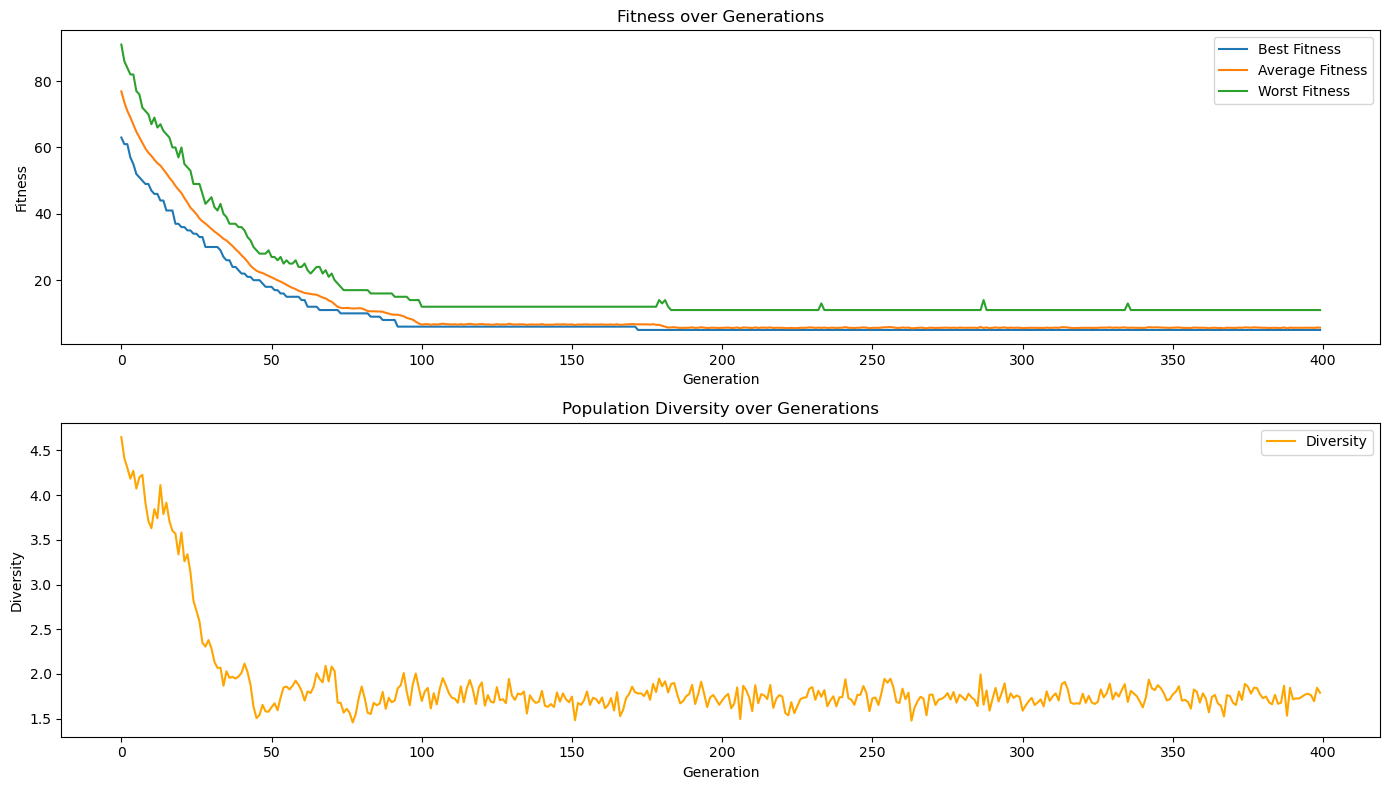

In [143]:
plot_fitness_data(best_fitness_data)